# eda009
room_fqid系列　編集距離

In [97]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [98]:
@dataclass
class Cfg:
    exp_name = "eda009"
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")
cfg = Cfg()

In [99]:
with open(cfg.prep_dir + 'room_fqid_encoder.pkl', 'rb') as f:
    room_fqid_encoder = pickle.load(f) 


In [101]:
group = "5-12"
df = pd.read_csv(cfg.prep_dir + f"train{group}_cleaned.csv")
labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")

In [102]:
df["room_fqid"] = df["room_fqid"].map(room_fqid_encoder)
df = df[df["room_fqid"]!=df["room_fqid"].shift(1)].copy()
agg_df = df.groupby("session_id")["room_fqid"].apply(list).reset_index()

In [103]:
agg_df["room_fqid_seq_len"] = agg_df["room_fqid"].apply(len)

In [104]:
agg_df["room_fqid"] = agg_df["room_fqid"].apply(lambda x: " ".join(x))

In [105]:
labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)

In [106]:
labels = labels.groupby("session_id")["correct"].mean().reset_index()

In [107]:
agg_df = agg_df.merge(labels, on="session_id", how="left")

In [108]:
result = agg_df.groupby("room_fqid").agg({"room_fqid_seq_len":"max", "room_fqid":"count", "correct":"mean"})

In [109]:
result.columns = ["seq_len", "cnt", "correct"]

In [110]:
result = result.sort_values(["seq_len", "cnt", "correct"], ascending=(True, False, False))

In [111]:
result.head(20)

,seq_len,cnt,correct
room_fqid,,,
g c b h b c e i k l m l c e i e c n,18,1,0.700000
g c b h b c e i e c j k l m l c e i e c n,21,6618,0.736099
g c b h b c e i e c j k l m l n c e i e c n,22,2121,0.695757
g c b h b c e i e c j k l m l j c e i e c n,22,70,0.611429
g f c b h b c e i e c j k l m l c e i e c n,22,41,0.660976
g c b h b c e i e c j c k l m l c e i e c n,22,32,0.575000
g c b h b c e i e c j k l m l c e i e c l n,22,21,0.690476
g c b h b c e i e c j k l m l k c e i e c n,22,18,0.594444
g c b h b c e i e c j k n l m l c e i e c n,22,10,0.640000


In [60]:
ideal_seq = "g c b h b c e i e c j k l m l c e i e c n"

In [61]:
import Levenshtein

In [67]:
leven_dists = {room_fqid: Levenshtein.distance(room_fqid, ideal_seq) for room_fqid in agg_df["room_fqid"].unique()}

In [76]:
result["leven_dist"] = result.index.map(leven_dists)

In [77]:
result

,seq_len,cnt,correct,leven_dist
room_fqid,,,,
g c b h b c e i k l m l c e i e c n,18,1,0.700000,6
g c b h b c e i e c j k l m l c e i e c n,21,6618,0.736099,0
g c b h b c e i e c j k l m l n c e i e c n,22,2121,0.695757,2
g c b h b c e i e c j k l m l j c e i e c n,22,70,0.611429,2
g f c b h b c e i e c j k l m l c e i e c n,22,41,0.660976,2
...,...,...,...,...
g c b h b c e i e c e c d c e i e c d c e i e c j k l m l n c b h b h b h b c e i e c e c n c l j k j c f j f k j n c b h b c f n l m l m l n c d c e i e c f n k l j c e i e i e c n,91,1,0.100000,140
g c e c f g c d c e c g c b h b c b h b c f c e i e c e i e c b h b c d c j k l m l n c b h b c f j c d c e i e c k c b c l m l j n f k j c b h b c d c k j f k c e i e c n j l m l n,91,1,0.100000,140
g c d c e c b h b c e i e c b h b c e i e c b h b c j k n c b h b c d c e c k c n j f c e i e c d c b h b c n j f c b h b c e i e c f j n k l m l n c b h b c e i e c b h b c d c l m l k n,94,1,0.200000,146


Text(0, 0.5, 'correct_rate')

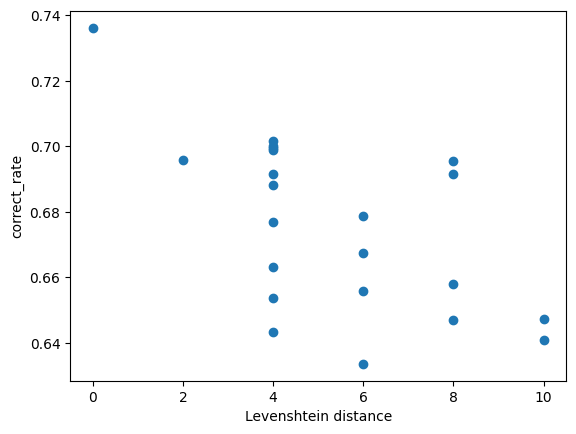

In [84]:
plt.scatter(result[result["cnt"]>100]["leven_dist"], result[result["cnt"]>100]["correct"])
plt.xlabel("Levenshtein distance")
plt.ylabel("correct_rate")

In [58]:
result.tail(20)

,seq_len,cnt,correct
room_fqid,,,
g c d c b h b c e i e c b h b h b c j k l m l n c b h b c e i e c d c b h b c e i e c k n k l m l m l j f c b h b c e i e c d c e c b h b c l j c n,74,1,0.1
g c d c e c b h b c d c e i e c b h b c d c f n f c d c e i e c b h b c d c j k l c d c b h b c e i e c l m l f n j c d c b h b c e i e c d c b h b c n,76,1,0.2
g c d c b h b c n f c d c n c e i e c b c e i e c b h b c j k l m l c b h b c n k l c e i e c n c b c d c e i e c j l m l n c d c b h b c e i e c b c n,76,1,0.1
g c b h b c b c e i e i e c d c e c j k l m l c b h b c e c n j n l f l j k c b c e i e c b h b h b c e c d c l m l f k l m l n f j k c b h b c e i e c n,77,1,0.5
g f c g f c e c b h b c n f n c b h b c e i e c d c e i e c j k l m l j k n l k n f c b h b c e i e c b h b c j k l f n c e i e i e c d c n k j l m l k n,77,1,0.3
g c e c d c b h b c e i e c d c b h b c j k l m l m l f c b h b c e i e c d c n j k f l n j c e i e c b h b c b c d c l f j c e i e c b c b h b c l m l f n,78,1,0.2
g c b h b c e c n c e i e c j k j n c e i e c e i e i e c j n c b h b c e i e c k j c b h b c d c e i e i e c j k n c b h b c d c e c k l k l m l n c e i e c n,80,1,0.7
g c f c d c e c e c b h b c e i e c b c n c b h b c d c e i e c j k l m l k f j f l c b h b c e i e c e c d c b h b c e c e i e c d c b h b c d c e c b h b c n,80,1,0.3
g f g f c d c e c b h b c d c b c n c f c e c d c e c b h b c n c b h b c e i e c b h b c e i e c b h b c n j k l f k l k l m l n f j n c e c e i e c b h b c n,80,1,0.1


In [112]:
group = "0-4"
df = pd.read_csv(cfg.prep_dir + f"train{group}_cleaned.csv")
labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")

df["room_fqid"] = df["room_fqid"].map(room_fqid_encoder)
df = df[df["room_fqid"]!=df["room_fqid"].shift(1)].copy()
agg_df = df.groupby("session_id")["room_fqid"].apply(list).reset_index()
agg_df["room_fqid_seq_len"] = agg_df["room_fqid"].apply(len)
agg_df["room_fqid"] = agg_df["room_fqid"].apply(lambda x: " ".join(x))
labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
labels = labels.groupby("session_id")["correct"].mean().reset_index()
agg_df = agg_df.merge(labels, on="session_id", how="left")
result = agg_df.groupby("room_fqid").agg({"room_fqid_seq_len":"max", "room_fqid":"count", "correct":"mean"})
result.columns = ["seq_len", "cnt", "correct"]
result = result.sort_values(["seq_len", "cnt", "correct"], ascending=(True, False, False))
result.head(20)

,seq_len,cnt,correct
room_fqid,,,
a b c f g,5,1,1.000000
a b c d f g,6,1,1.000000
a b c d c f g,7,11035,0.905875
a b c d c e c f g,9,3757,0.876675
a b a b c d c f g,9,612,0.885076
a b c d c b c f g,9,575,0.893333
a b c d c d c f g,9,392,0.851190
a b c b c d c f g,9,327,0.884811
a b c d c f g f g,9,4,0.916667


In [113]:
ideal_seq = "a b c d c f g"

In [114]:
leven_dists = {room_fqid: Levenshtein.distance(room_fqid, ideal_seq) for room_fqid in agg_df["room_fqid"].unique()}
result["leven_dist"] = result.index.map(leven_dists)

Text(0, 0.5, 'correct_rate')

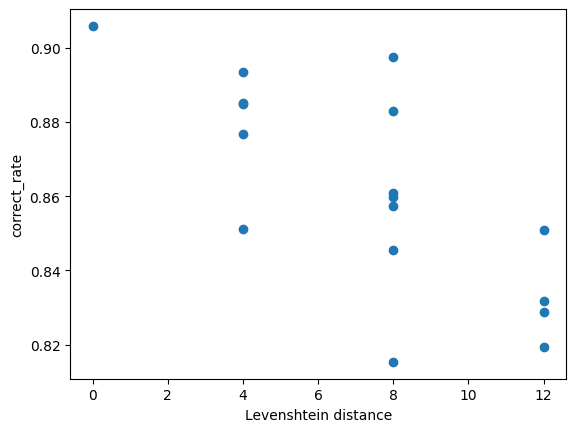

In [115]:
plt.scatter(result[result["cnt"]>100]["leven_dist"], result[result["cnt"]>100]["correct"])
plt.xlabel("Levenshtein distance")
plt.ylabel("correct_rate")

In [116]:
group = "13-22"
df = pd.read_csv(cfg.prep_dir + f"train{group}_cleaned.csv")
labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")

df["room_fqid"] = df["room_fqid"].map(room_fqid_encoder)
df = df[df["room_fqid"]!=df["room_fqid"].shift(1)].copy()
agg_df = df.groupby("session_id")["room_fqid"].apply(list).reset_index()
agg_df["room_fqid_seq_len"] = agg_df["room_fqid"].apply(len)
agg_df["room_fqid"] = agg_df["room_fqid"].apply(lambda x: " ".join(x))
labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
labels = labels.groupby("session_id")["correct"].mean().reset_index()
agg_df = agg_df.merge(labels, on="session_id", how="left")
result = agg_df.groupby("room_fqid").agg({"room_fqid_seq_len":"max", "room_fqid":"count", "correct":"mean"})
result.columns = ["seq_len", "cnt", "correct"]
result = result.sort_values(["seq_len", "cnt", "correct"], ascending=(True, False, False))
result.head(20)

,seq_len,cnt,correct
room_fqid,,,
n c b o b c e i e c b o b c p c q r l m l c e i e c s,27,2865,0.786667
n c b o b h b c e i e c b c p c q r l m l c e i e c s,27,1,1.000000
n c b o b o b c e i e c b o b c p c q r l m l i e c s,27,1,0.800000
n c b o b c e i e c b o b c p c q r l m l s c e i e c s,28,423,0.774468
n c b o b c e i e c b o b c p c q r c l m l c e i e c s,28,46,0.773913
n c b o b c e i e c b o b c p c q r q l m l c e i e c s,28,35,0.805714
n c b o b c e i e c b o b c p c q r s l m l c e i e c s,28,31,0.741935
n c b o b c e i e c b o b c p c q r l m l c e i e c r s,28,13,0.738462
n c b o b c e i e c b o b c p c q r l m l c e i e c q s,28,9,0.733333


In [117]:
ideal_seq = "n c b o b c e i e c b o b c p c q r l m l c e i e c s"

In [118]:
leven_dists = {room_fqid: Levenshtein.distance(room_fqid, ideal_seq) for room_fqid in agg_df["room_fqid"].unique()}
result["leven_dist"] = result.index.map(leven_dists)

Text(0, 0.5, 'correct_rate')

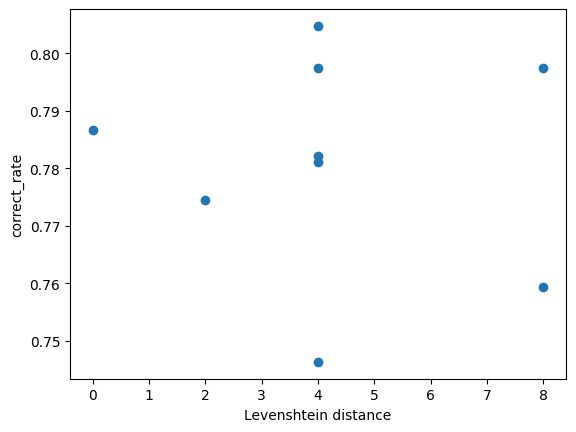

In [119]:
plt.scatter(result[result["cnt"]>100]["leven_dist"], result[result["cnt"]>100]["correct"])
plt.xlabel("Levenshtein distance")
plt.ylabel("correct_rate")

In [120]:
df = pd.read_csv(cfg.prep_dir + f"train{group}_cleaned.csv")

In [123]:
import polars as pl
df = pl.from_pandas(df)

In [127]:
df = df.with_columns(pl.col("room_fqid").map_dict(room_fqid_encoder).alias("room_fqid_encode"))

In [129]:
import Levenshtein

In [131]:
df.groupby("session_id").agg(pl.col("room_fqid_encode").filter(pl.col("room_fqid_encode")!=pl.col("room_fqid_encode").shift(1)).str.concat(" ").apply(lambda x: Levenshtein.distance(x, ideal_seq)).alias("room_fqid_leven_dist"))

session_id,room_fqid_leven_dist
i64,i64
21080411512159520,52
20110212122599456,28
22000409381228160,0
21040314191496960,6
22020421304234496,8
21000514035495936,82
21000520052524320,6
21060111232119616,22
21070314195690624,16
